# Model-map illustration of results

## Introduction

In this demo, we illustrate the use of the model-map illustration of result objects. This illustrates the same results as `rsatoolbox.vis.plot_model_comparison` in a different format. The method places the data-RDM at the center and the models around it such that being close to the data represets high model performance. The placement around the circle is then used to represent the dissimilarities between models.

To create this plot the overall method internally runs the following steps:
1. Extract the model-performances, error-bars and significance tests
2. Compute model similarites
3. Show the model similarity matrix
4. Embed the models using MDS (using `weighted_MDS` or `custom_MDS`)
5. Plot the Shepard plot for the embedding (using `show_Shepard_plot`)
6. Make the first plot (using `plot_model_map_elastic`)
7. Make the second plot (using `plot_model_map`)

The named individual steps can be run separately, but for standard use running `map_model_comparison` which performs all steps coherently should be sufficient. 

### Computing some results
To have something to plot, we first regenerate the analyses from the bootstrapping demo (demo_bootstrap).

Standard imports:

In [1]:
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import rsatoolbox

Generating models:

In [2]:
matlab_data = io.matlab.loadmat('rdms_inferring/modelRDMs_A2020.mat')
matlab_data = matlab_data['modelRDMs']
n_models = len(matlab_data[0])
model_names = [matlab_data[0][i][0][0] for i in range(n_models)]
measurement_model = [matlab_data[0][i][1][0] for i in range(n_models)]
rdms_array = np.array([matlab_data[0][i][3][0] for i in range(n_models)])
model_rdms = rsatoolbox.rdm.RDMs(rdms_array,
                            rdm_descriptors={'brain_computational_model':model_names,
                                             'measurement_model':measurement_model},
                            dissimilarity_measure='Euclidean'
                           )
matlab_data = io.matlab.loadmat('rdms_inferring/noisyModelRDMs_A2020.mat')
repr_names_matlab = matlab_data['reprNames']
fwhms_matlab = matlab_data['FWHMs']
noise_std_matlab = matlab_data['relNoiseStds']
rdms_matlab = matlab_data['noisyModelRDMs']
repr_names = [repr_names_matlab[i][0][0] for i in range(repr_names_matlab.shape[0])]
fwhms = fwhms_matlab.squeeze().astype('float')
noise_std = noise_std_matlab.squeeze().astype('float')
rdms_matrix = rdms_matlab.squeeze().astype('float')

i_rep = 2 #np.random.randint(len(repr_names)) 
i_noise = 1 #np.random.randint(len(noise_std))
i_fwhm = 0 #np.random.randint(len(fwhms))

rdms_data = rsatoolbox.rdm.RDMs(rdms_matrix[:, i_rep, i_fwhm, i_noise, :].transpose())
models = []
for i_model in np.unique(model_names):
    rdm_m = model_rdms.subset('brain_computational_model', i_model).subset('measurement_model','complete')
    m = rsatoolbox.model.ModelFixed(i_model, rdm_m)
    models.append(m)
models_flex = []
for i_model in np.unique(model_names):
    models_flex.append(rsatoolbox.model.ModelSelect(i_model,
        model_rdms.subset('brain_computational_model', i_model)))

Computing results (Fixed model analysis, crossvalidation, and bootstrap-crossvalidation):

In [3]:
# This may take a short while
results_1 = rsatoolbox.inference.eval_fixed(models, rdms_data, method='corr')
train_set, test_set, ceil_set = rsatoolbox.inference.sets_k_fold(rdms_data, k_pattern=3, k_rdm=2)
results_2_cv = rsatoolbox.inference.crossval(models_flex, rdms_data, train_set, test_set,
                                             ceil_set=ceil_set, method='corr')
results_3_full = rsatoolbox.inference.bootstrap_crossval(models_flex, rdms_data, k_pattern=4, k_rdm=2, method='corr', N=100)



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.76it/s]


Model comparisons: two-tailed, FDR q < 0.01 (36 model-pair comparisons)
Error bars indicate the standard error of the mean.
One-sided comparisons of each model performance against 0 and against the lower-bound estimate of the noise ceiling are Bonferroni-corrected for 9 models.
Inter-RDM distances were measured by the Pearson correlation distance (proportional to squared Euclidean distance after RDM centering and divisive normalization).Inter-RDM distances are mapped as Pearson correlation distance (proportional to squared Euclidean distance after RDM centering and divisive normalization).

Estimating the bias due to noise of the inter-RDM distance estimates...
SE-based bias_of_sq_data_model_dist: 0.0766
Bootstrapping to estimate the bias of the squared data-model RDM distances...

Bootstrap-based bias_of_sq_data_model_dist: 0.1427


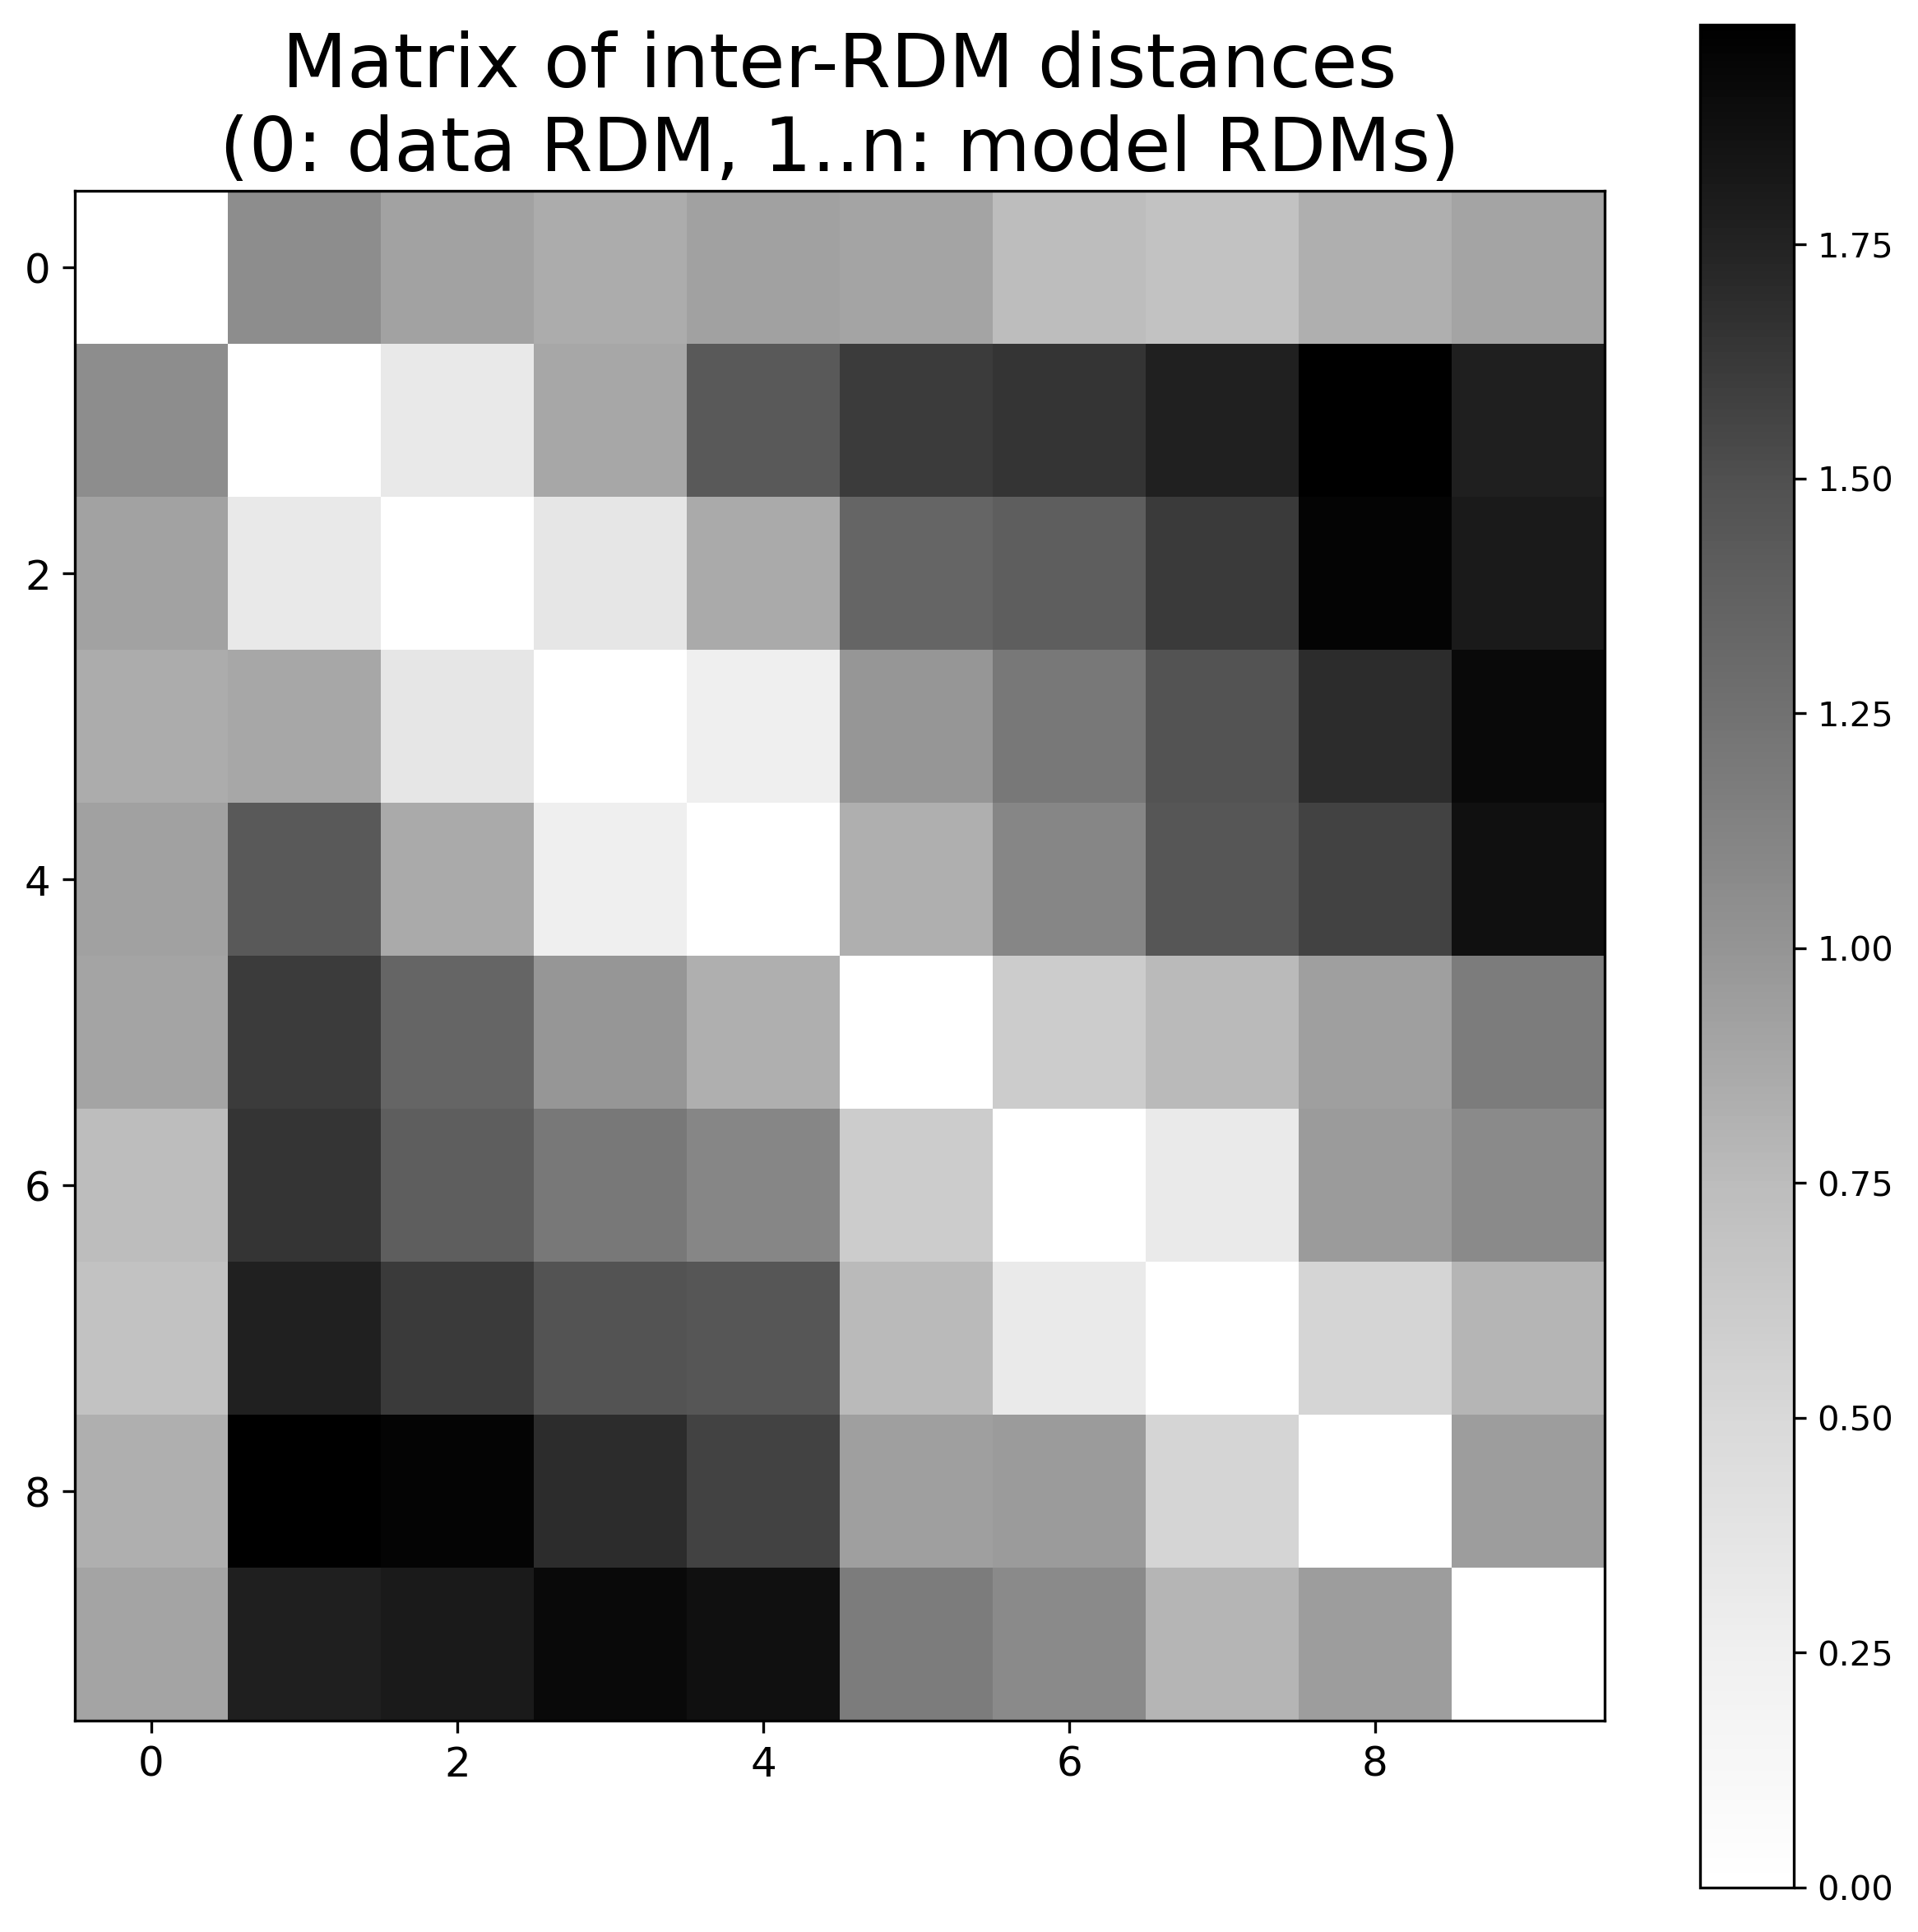


Performing MDS to map model RDMs around the data RDM, using custom MDS...
Pearson r(RDM dist, 2d-map dist): 0.9658
Pearson r(RDM dist, 2d-map dist) for model-data dists: 1.0000
Spearman r(RDM dist, 2d-map dist) for model-data dists: 1.0000


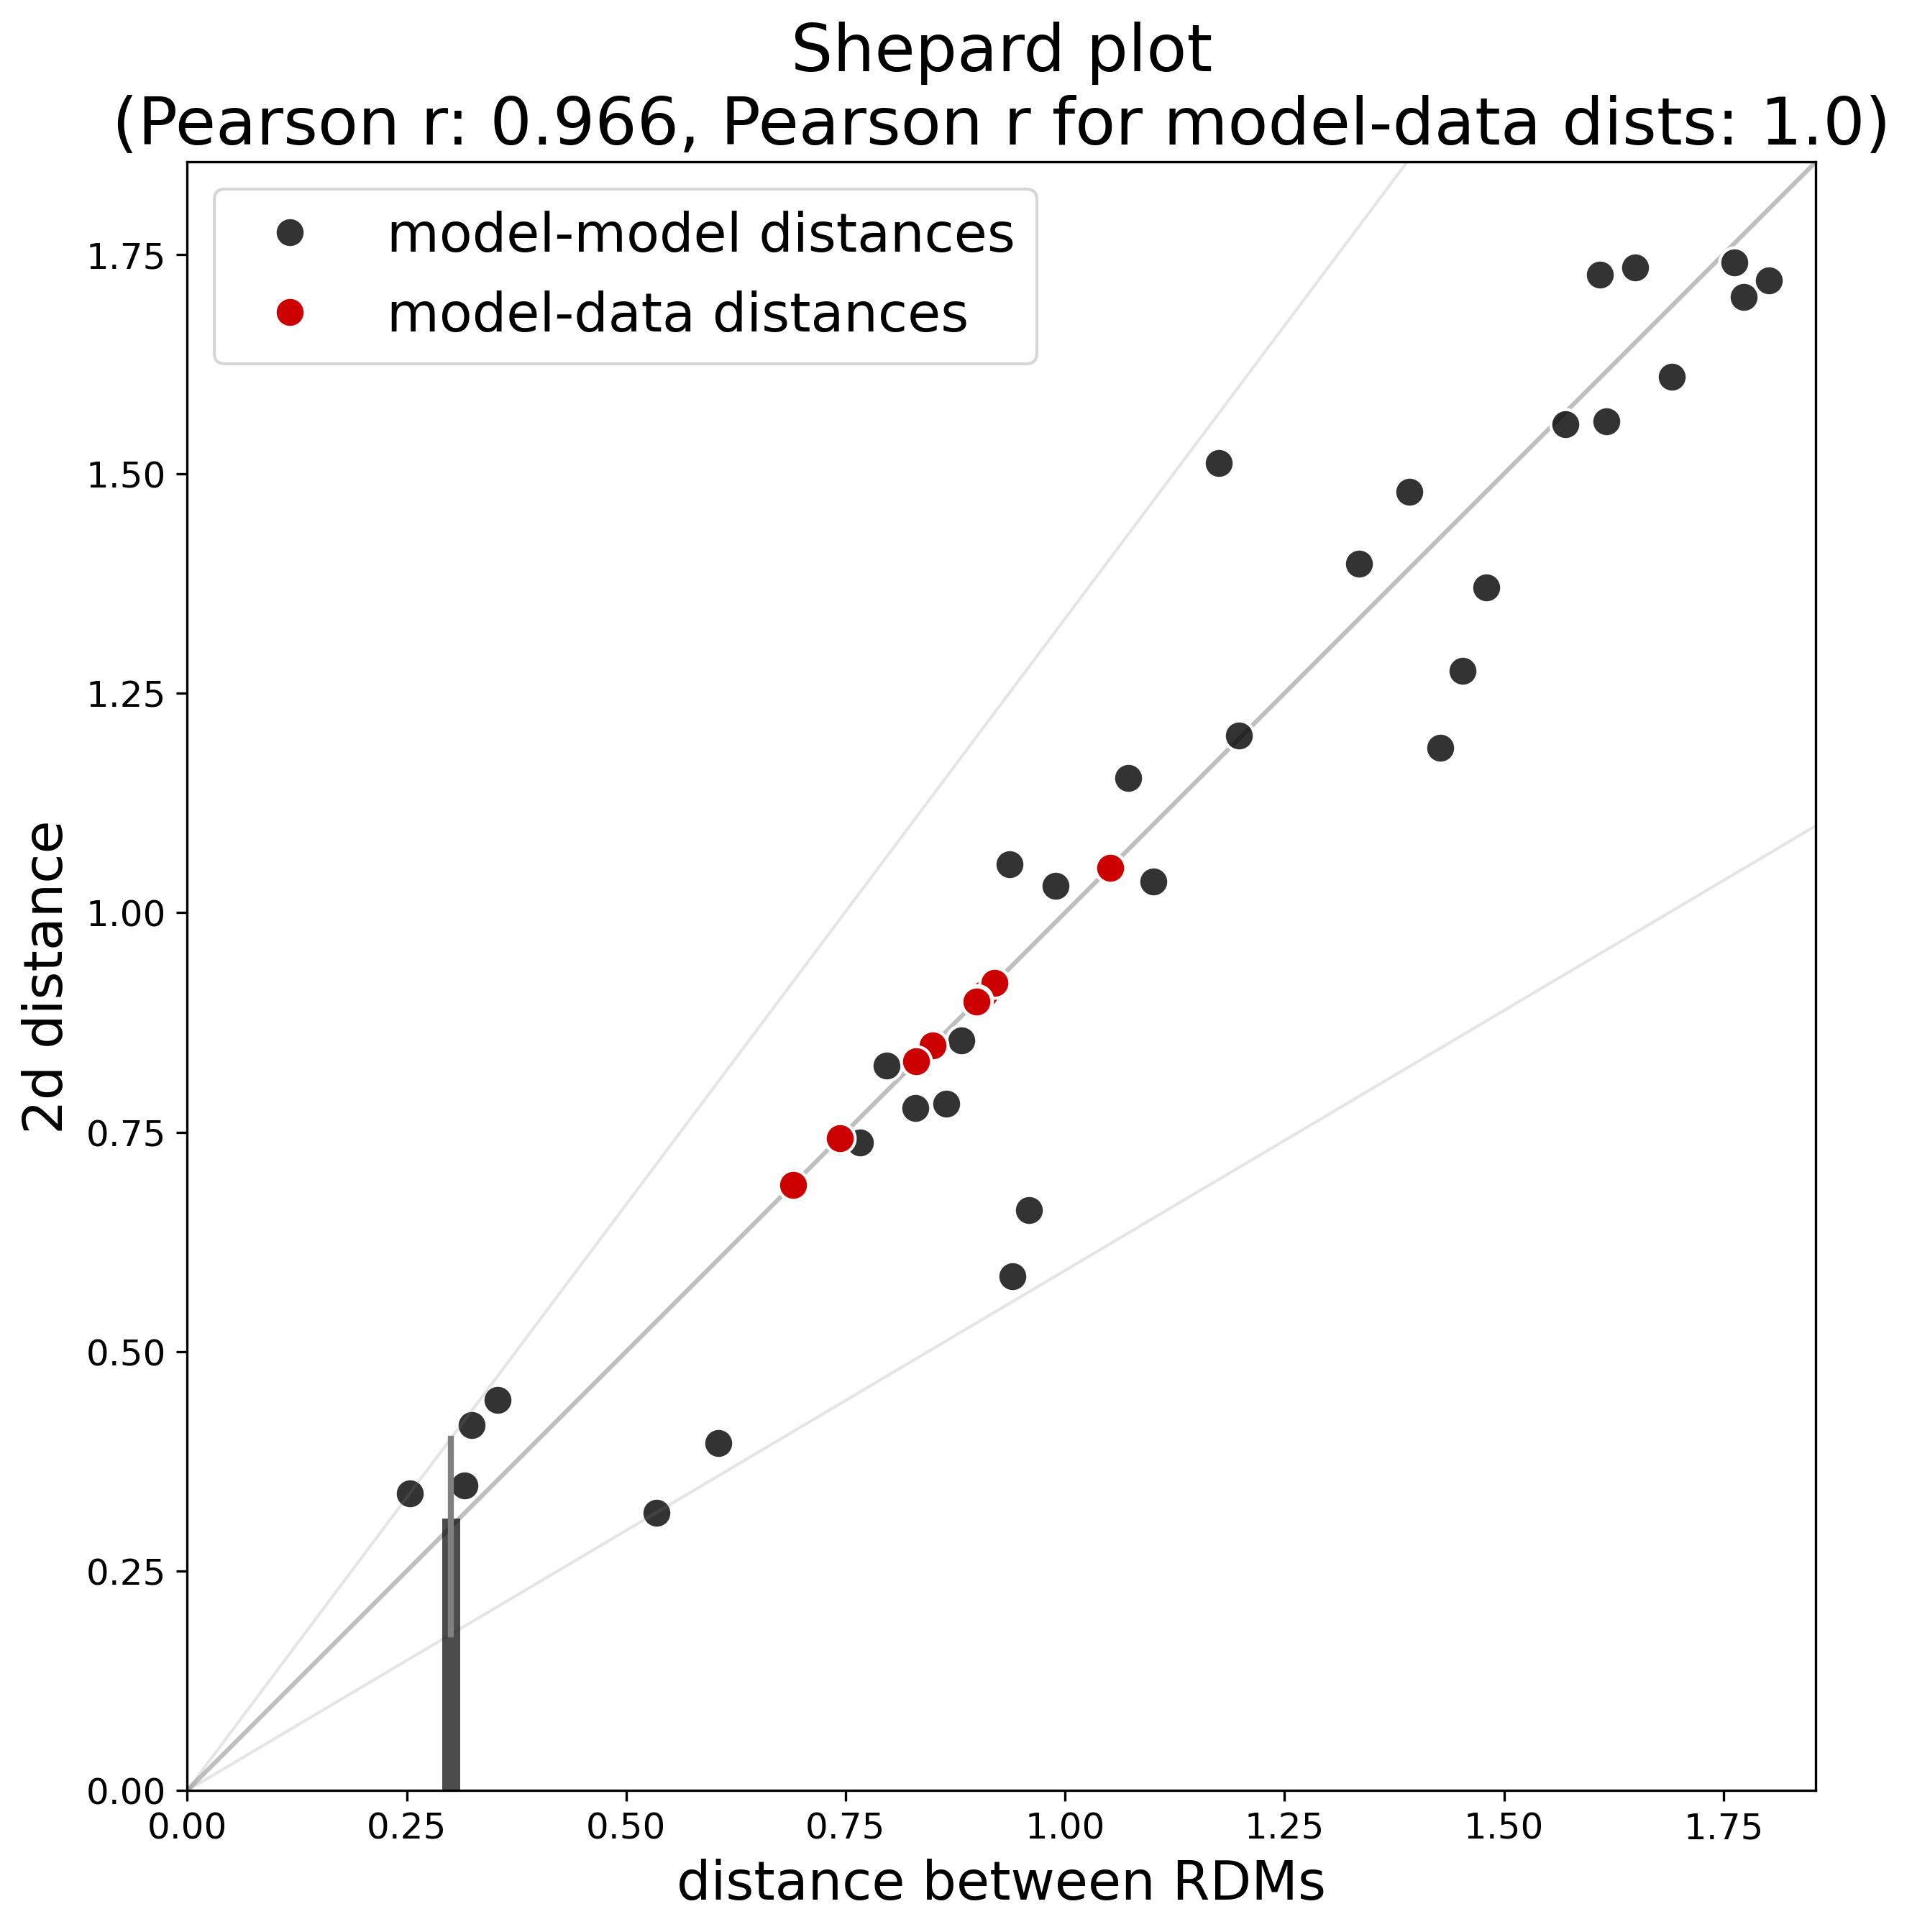

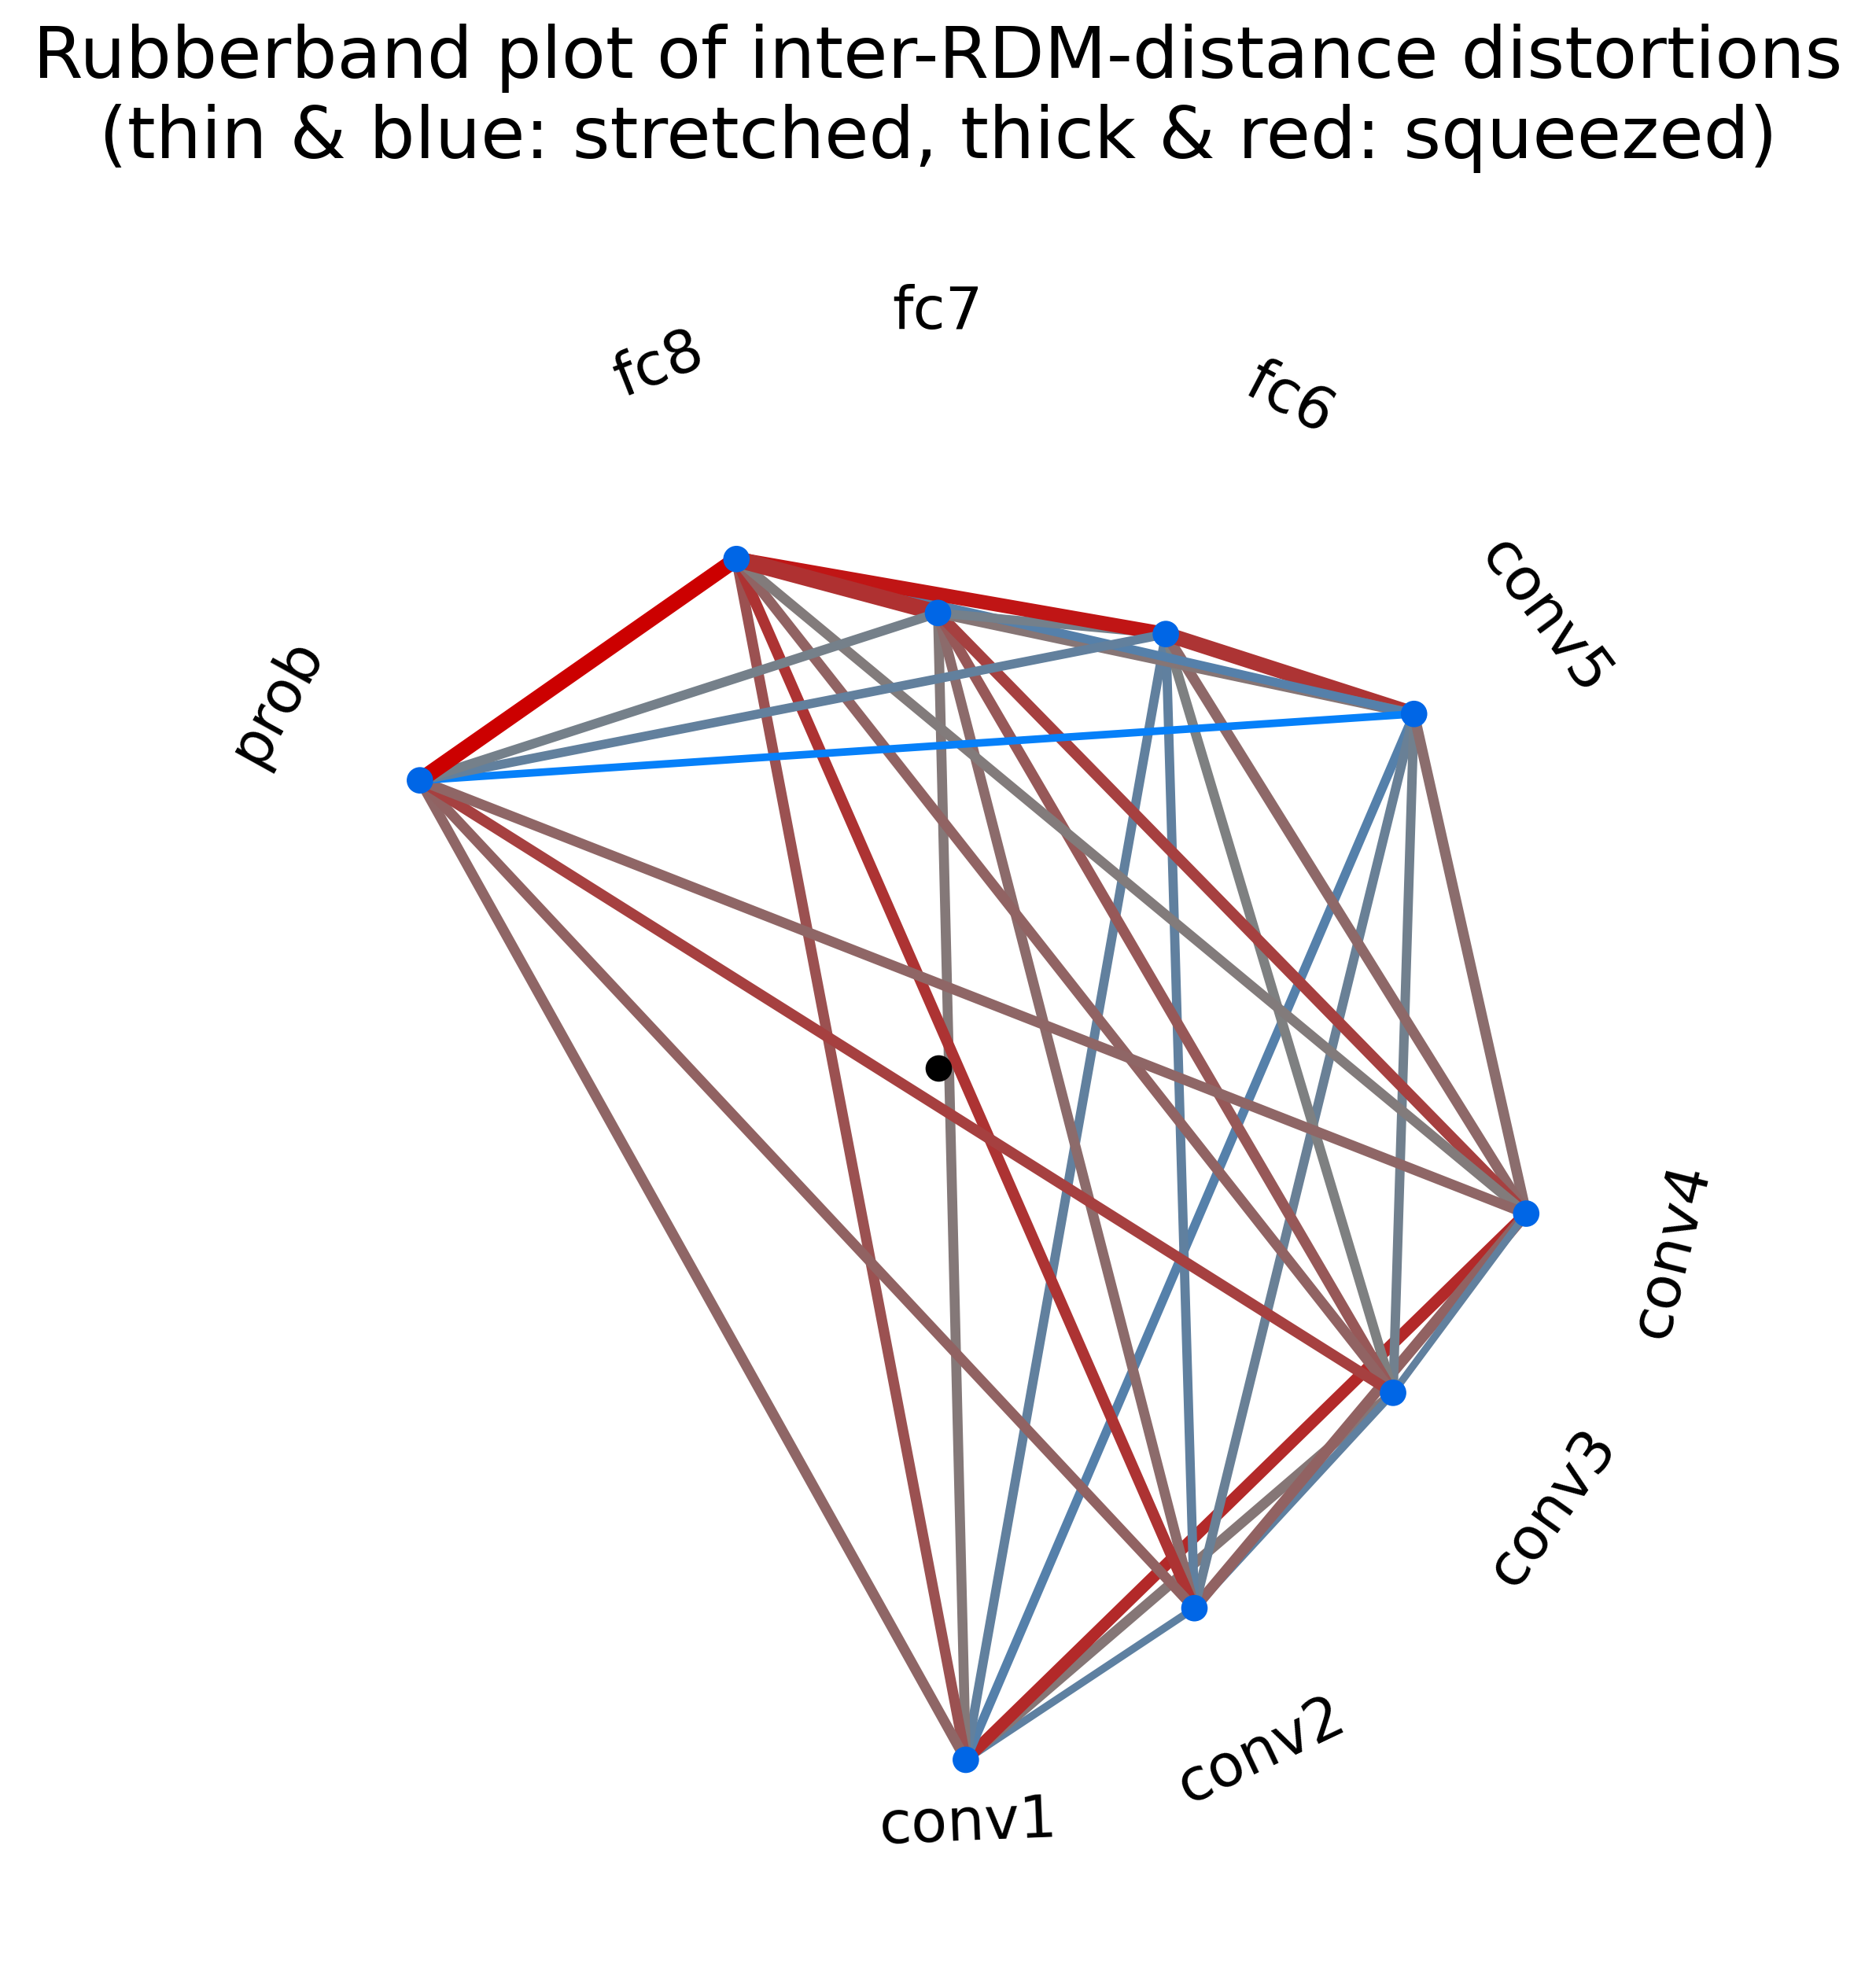

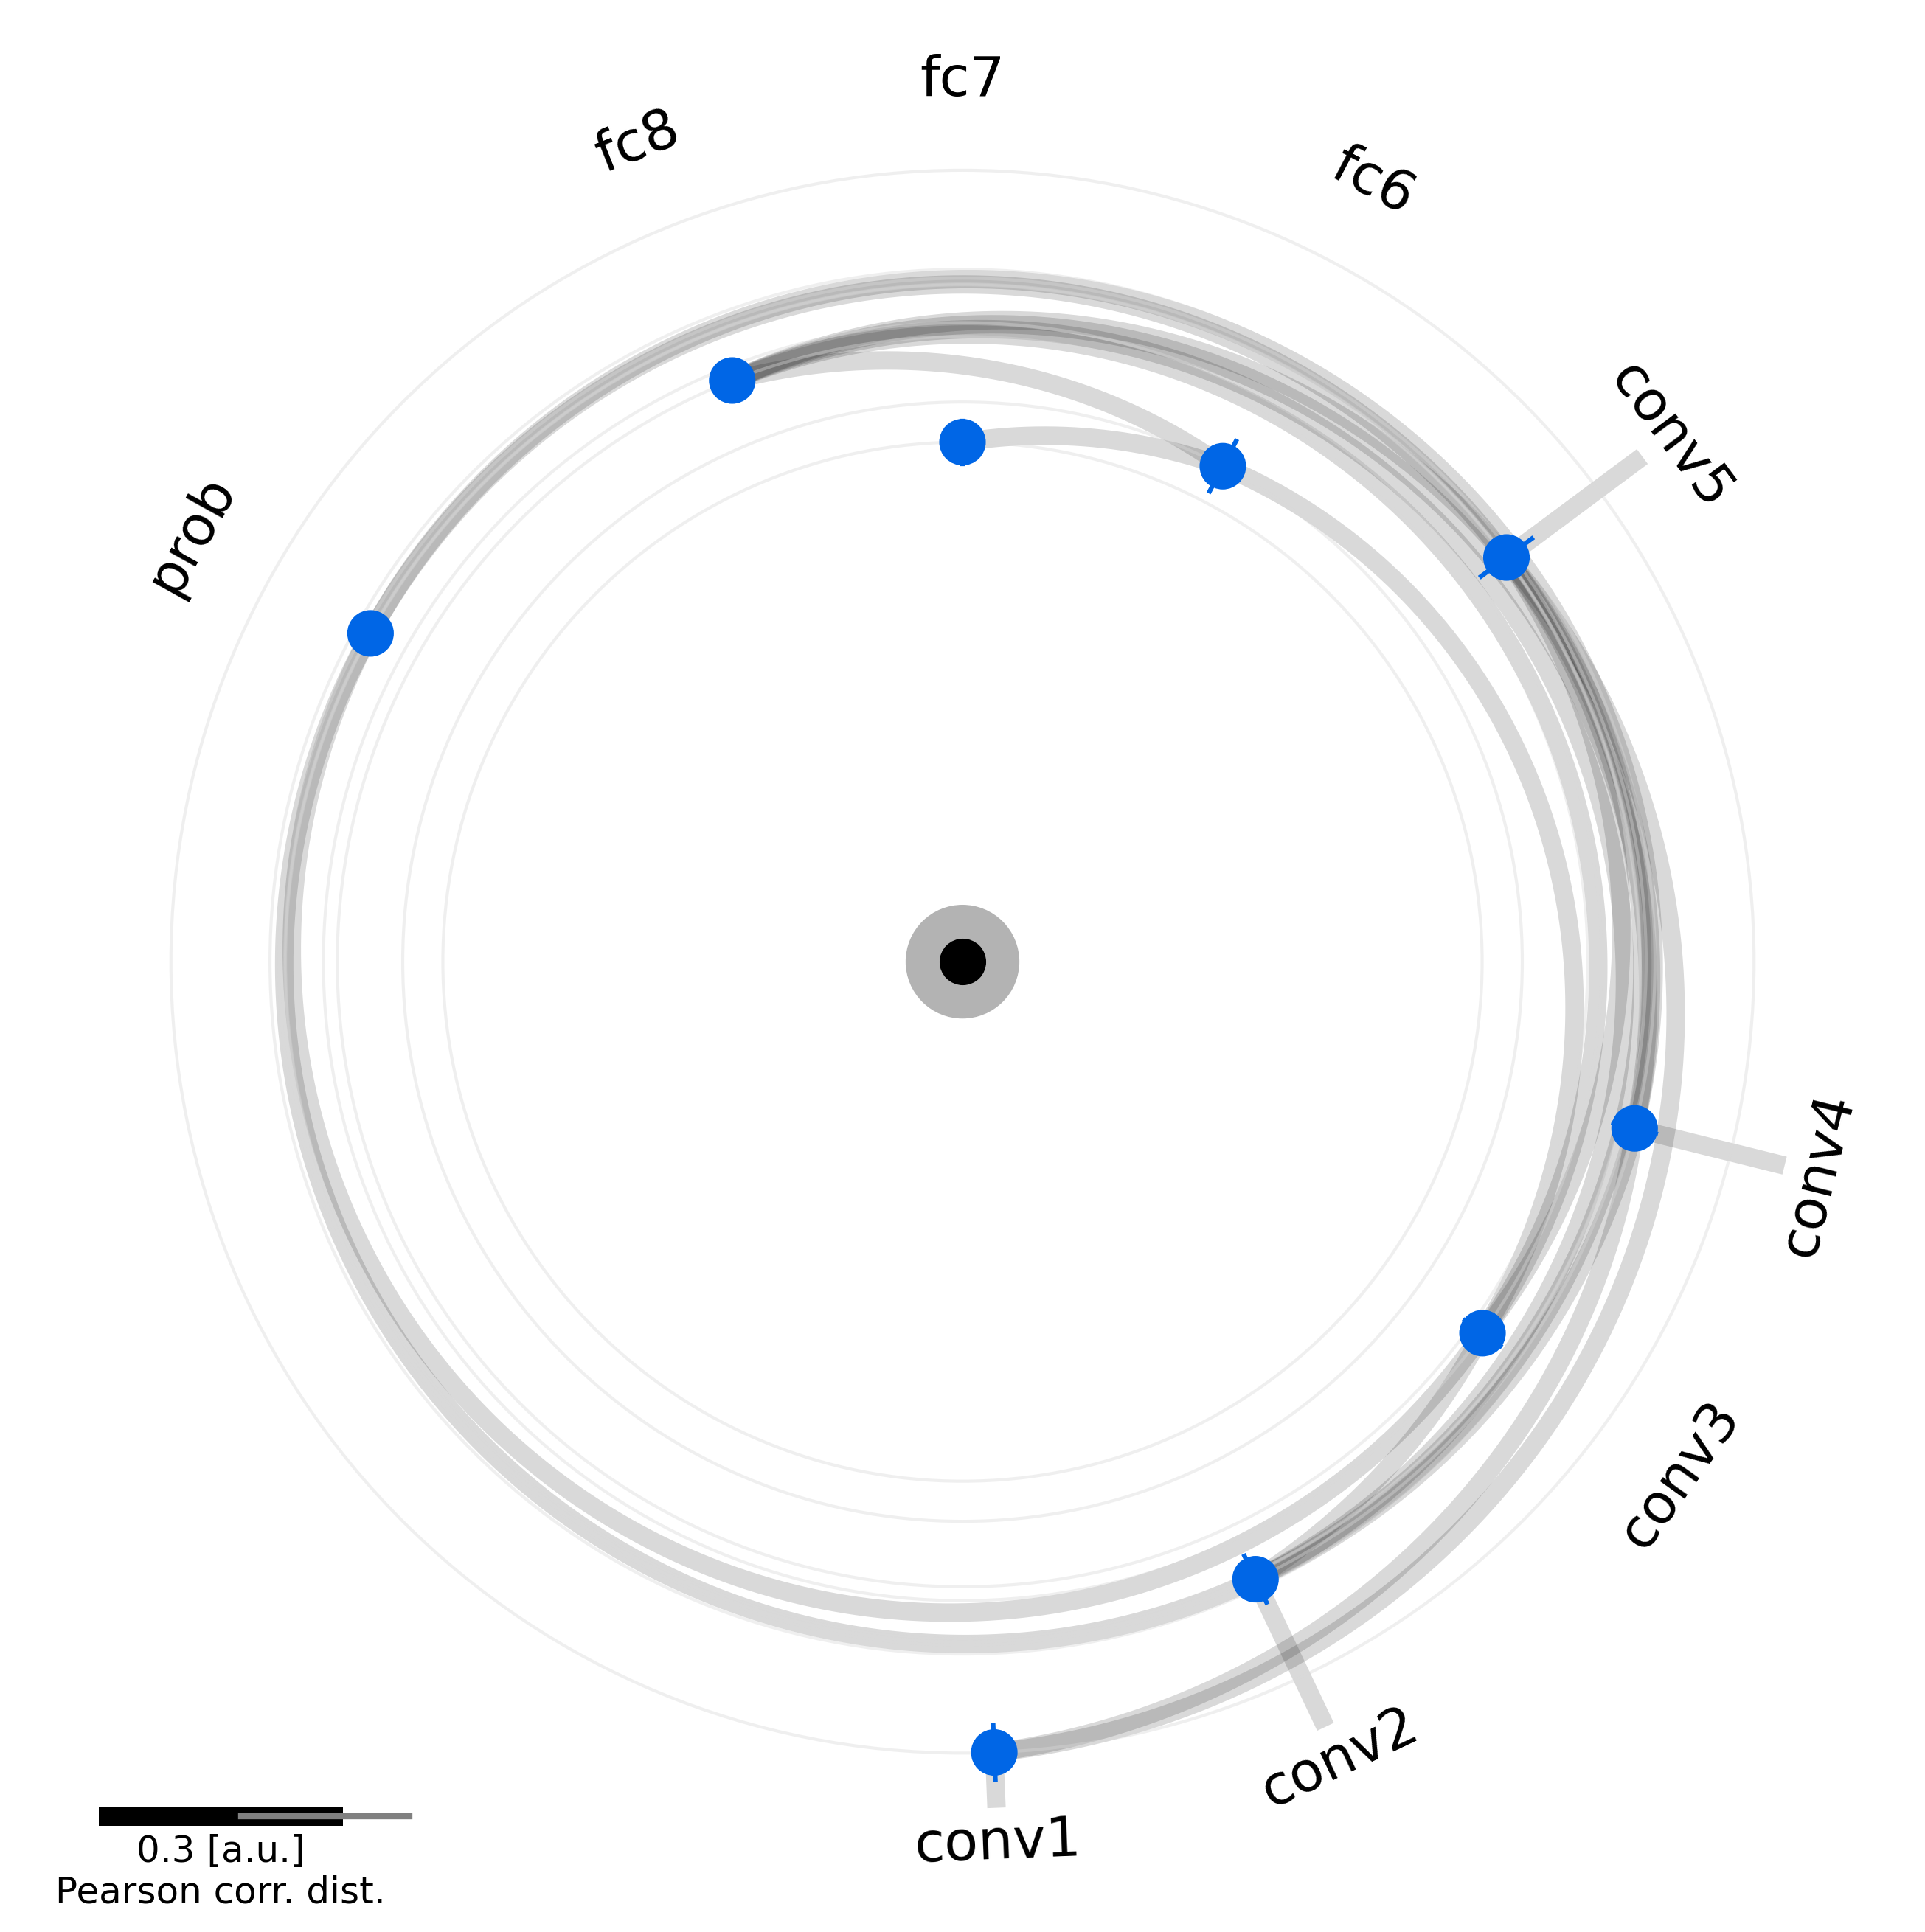

In [4]:
rsatoolbox.vis.map_model_comparison(results_1, rdms_data, error_bars='sem')


Tests deactivated because crossvalidation alone gives no uncertainty estimate.

FDR q < 0.01 (36 model-pair comparisons)
Error bars indicate the 99.0% confidence interval.Inter-RDM distances were measured by the Pearson correlation distance (proportional to squared Euclidean distance after RDM centering and divisive normalization).Inter-RDM distances are mapped as Pearson correlation distance (proportional to squared Euclidean distance after RDM centering and divisive normalization).

Estimating the bias due to noise of the inter-RDM distance estimates...
SE-based bias_of_sq_data_model_dist: 0.0783
Bootstrapping to estimate the bias of the squared data-model RDM distances...

Bootstrap-based bias_of_sq_data_model_dist: 0.1441


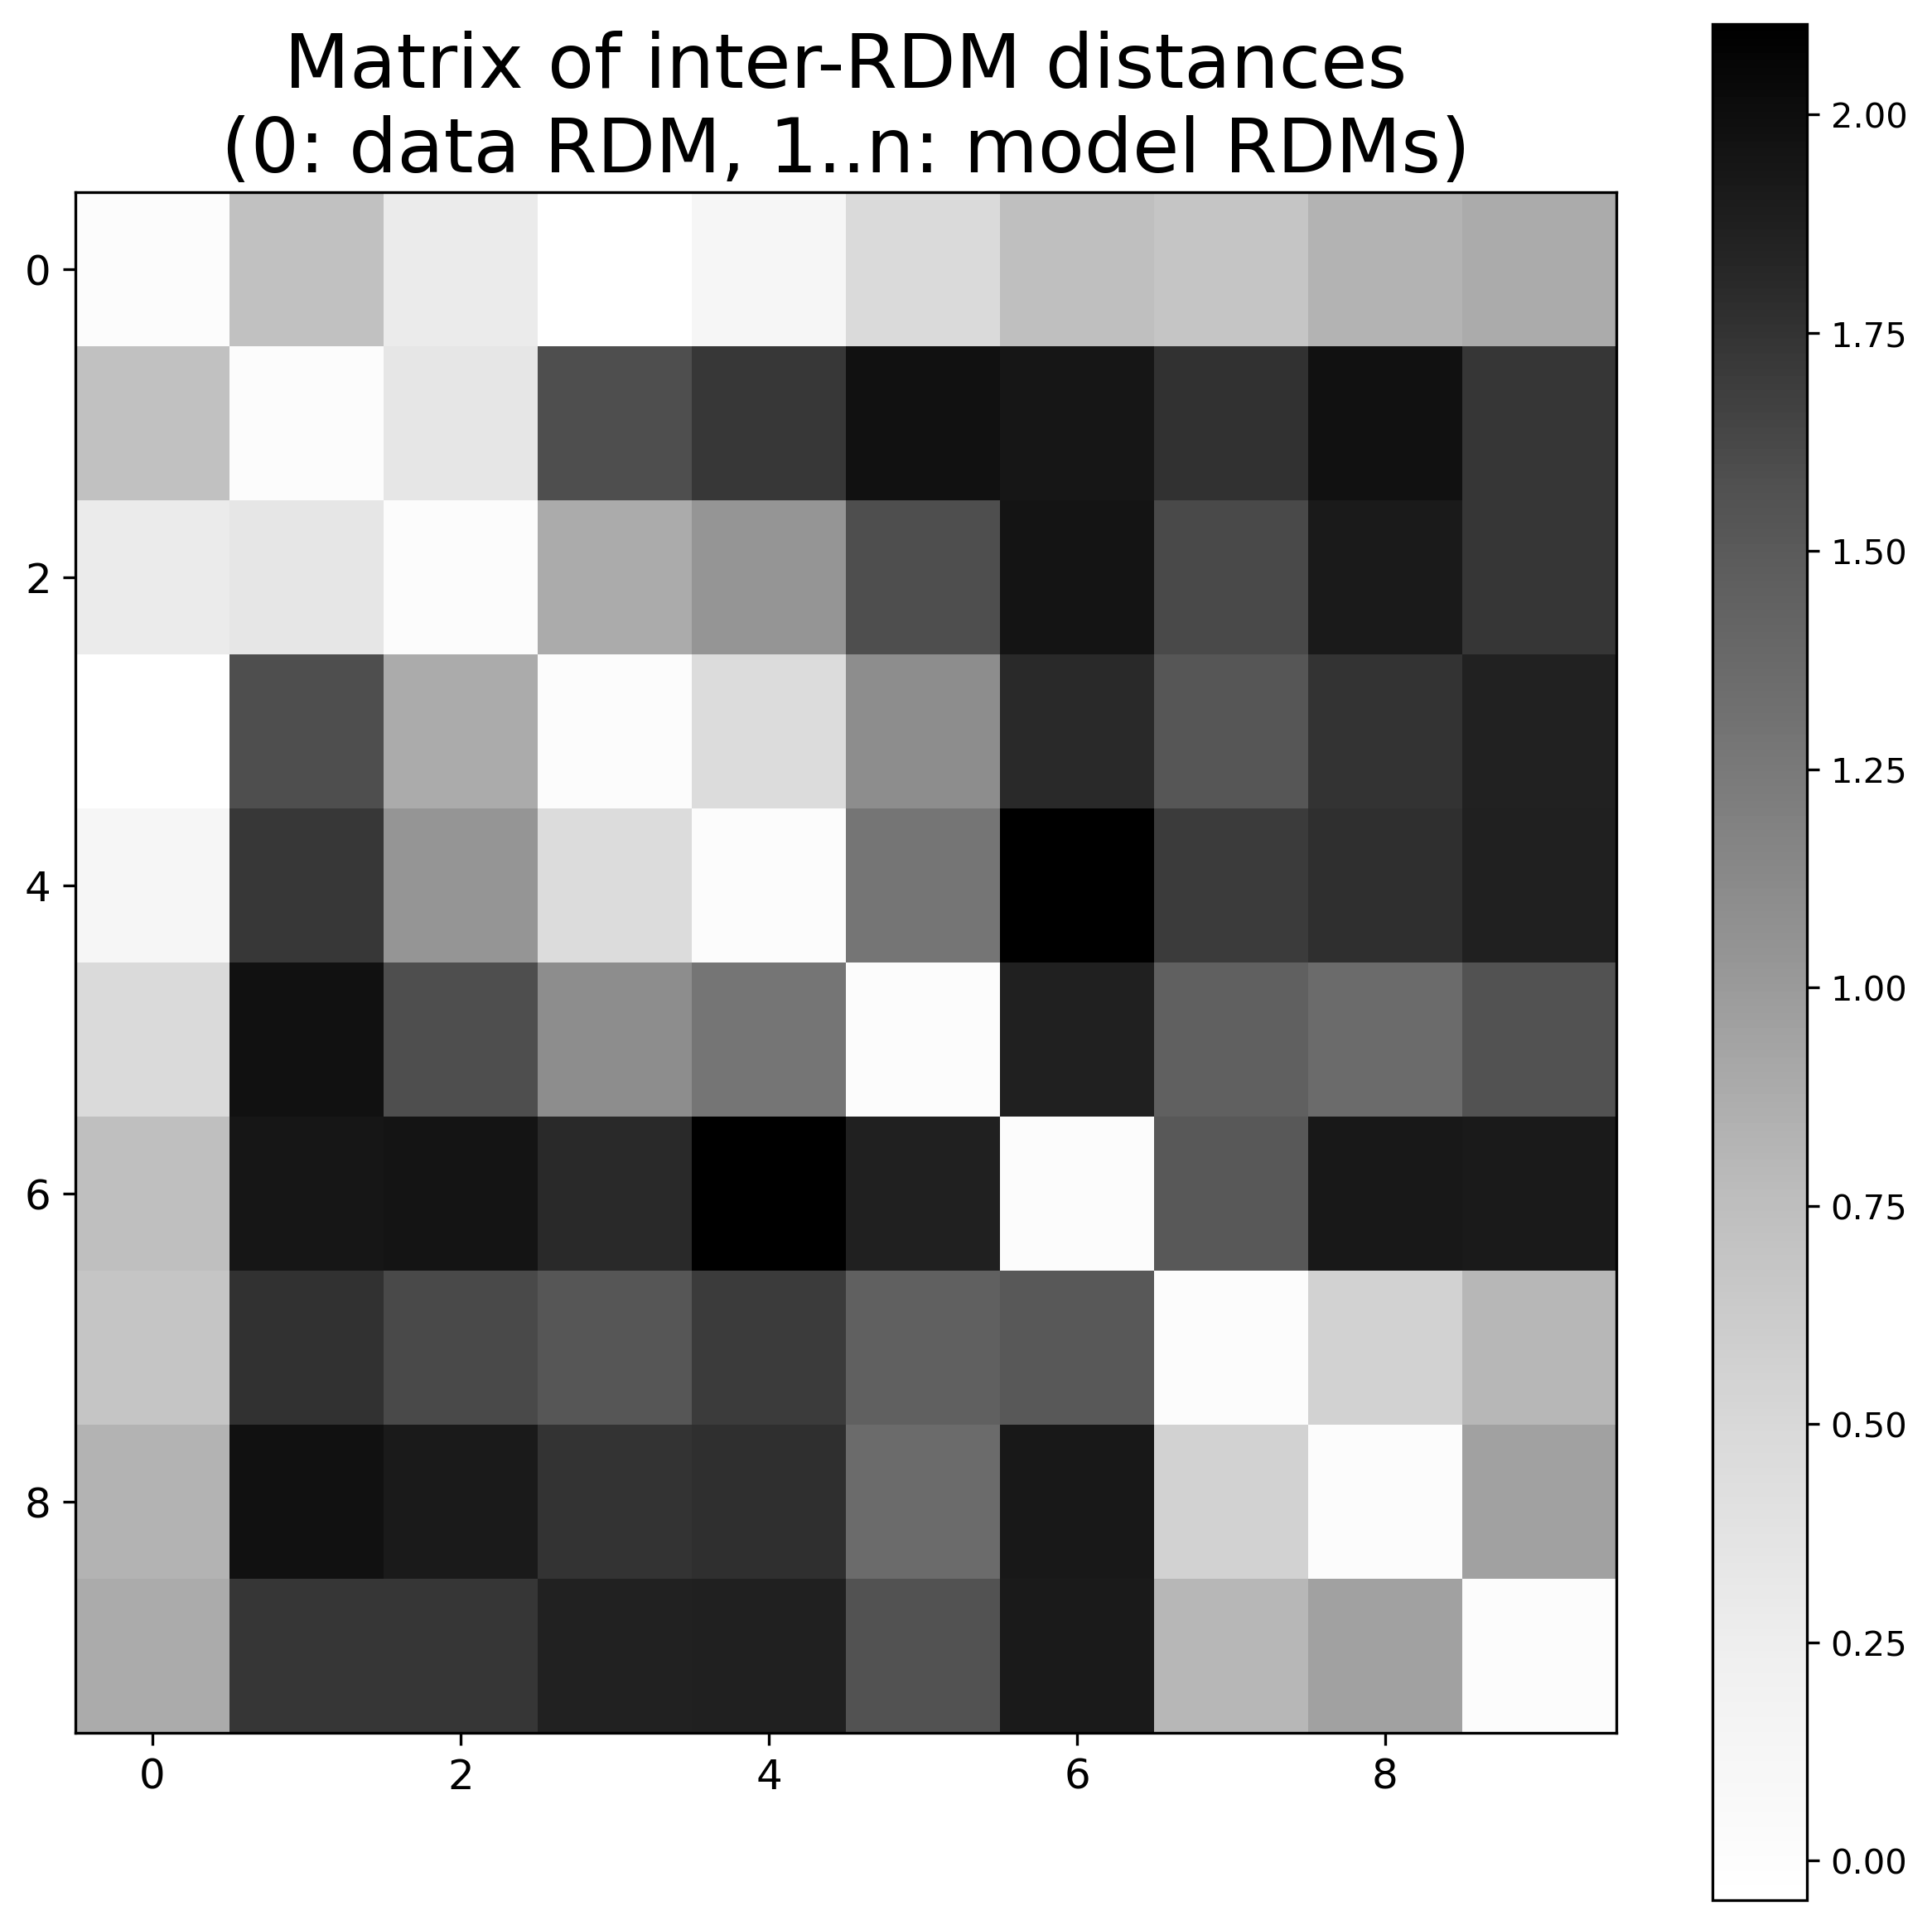


Performing MDS to map model RDMs around the data RDM, using custom MDS...
 MDS did not converge. Doubling number of iterations.


In [ ]:
# plot results
rsatoolbox.vis.map_model_comparison(
    results_2_cv, rdms_data=rdms_data)

In [ ]:
# plot results
rsatoolbox.vis.map_model_comparison(results_3_full, rdms_data=rdms_data, 
                                    error_bars='sem')